/tmp/ipykernel_11471/4229771793.py:71: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle(


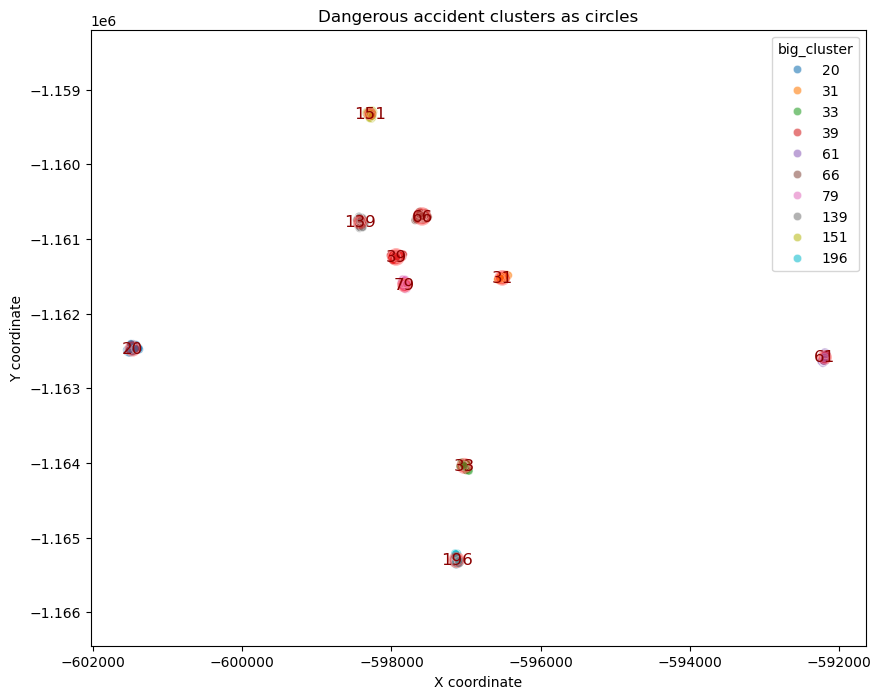

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import numpy as np
from matplotlib.patches import Circle

from utils import col_map

# Read data
df = pd.read_csv("data/brno_nehody.csv")
df.rename(columns=col_map, inplace=True)

# Take coordinates
coords = df[["x", "y"]].copy()

# Make pipeline, that scales x and y coordinates and then uses DBSCAN algorithm
# hyperparameters are: 
# - 20 meters area near one accident (eps) 
# - minimal number of samples to be considered core of cluster is 5
clusterizer = DBSCAN(eps=20, min_samples=5)
clusters = clusterizer.fit_predict(coords)

# Engineer new DataFrame feature (cluster id for every accident)
df["cluster"] = clusters

# take only big clusters (more than 50 accidents happened in cluster)
cluster_sizes = df['cluster'].value_counts()
big_clusters = cluster_sizes[cluster_sizes >= 50].index

df['big_cluster'] = df['cluster'].apply(lambda x: x if x in big_clusters else -1)
df_big = df[df['big_cluster'] != -1]

# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_big["x"], 
    y=df_big["y"], 
    hue=df_big["big_cluster"], 
    palette="tab10", 
    legend="full", 
    alpha=0.6
)

#store centers of the clusters
cluster_centers = []

for cluster_id in big_clusters:
    cluster_points = df_big[df_big['big_cluster'] == cluster_id][['x', 'y']]
    
    # Cluster center is mean of x and mean of y
    center_x = cluster_points['x'].mean()
    center_y = cluster_points['y'].mean()
    
    # Radius is maximal distance between center of the cluster and furthest point
    distances = np.sqrt((cluster_points['x'] - center_x)**2 + (cluster_points['y'] - center_y)**2)
    radius = distances.max()
    
    cluster_centers.append({
        'cluster_id': cluster_id,
        'center_x': center_x,
        'center_y': center_y,
        'radius': radius
    })

# Make Dataframe out of centers
df_clusters = pd.DataFrame(cluster_centers)

# Visualize clusters
for _, row in df_clusters.iterrows():
    circle = Circle(
        (row['center_x'], row['center_y']),   # center of the circle
        row['radius'],                        # radius
        color='red',                          
        alpha=0.3,                            
        edgecolor='darkred',
        lw=2
    )

    plt.gca().add_patch(circle)
    plt.text(row['center_x'], row['center_y'], str(int(row['cluster_id'])), 
             color='darkred', fontsize=12, ha='center', va='center')

plt.title("Dangerous accident clusters as circles")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.axis('equal')  
plt.show()

# Results:
# - Identified dangerous accident clusters using DBSCAN (eps=20, min_samples=5)
# - Filtered only large clusters (>=50 accidents) to focus on high-risk areas
# - Calculated cluster center (mean x, y) and radius (max distance to center)
# - Visualized clusters as circles on the map
# Usage:
# - df_clusters can be sent to frontend: each row contains cluster_id, center coordinates, and radius
# - Shows only the most dangerous zones for alerts, analytics, or city planning